In [1]:
import os
import pyro
import torch

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro.distributions as dist

from torch import Tensor
from tqdm.auto import trange
from pyro.nn import PyroModule, PyroSample, PyroParam
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive
from pyro.distributions import constraints
from pyro.infer.autoguide import AutoDiagonalNormal

os.chdir("../../")

from src.dgp_rff.outer_layer import SingleGP

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Read data
cwd = os.getcwd()

X_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_train.txt")
X_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_X_test.txt")
Y_train_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_train.txt")
Y_test_path = os.path.join(cwd, "folds", "synthetic_1_fold_1_Y_test.txt")

x_obs = np.loadtxt(X_train_path)
y_obs = np.loadtxt(Y_train_path)
x_val = np.loadtxt(X_test_path)
y_val = np.loadtxt(Y_test_path)

# Set plot limits and labels
xlims = [-0.2, 0.2]

# The X and Y have to be at least 2-dim
x_train = torch.from_numpy(x_obs).float().reshape(-1,1)
y_train = torch.from_numpy(y_obs).float()
x_test = torch.from_numpy(x_val).float().reshape(-1,1)
y_test = torch.from_numpy(y_val).float()

In [4]:
class Model(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, J=50):
        super().__init__()
        
        self.out_dim = out_dim
        self.model = SingleGP(in_dim, out_dim, J)

    def forward(self, x, y=None):
        mu = self.model(x).squeeze()

        scale = pyro.sample("sigma", dist.Gamma(.5, 1)).expand(self.out_dim)  # Infer the response noise

        # Sampling model
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.MultivariateNormal(mu, torch.diag(scale * scale)), obs=y)
            
        return mu

In [6]:
model = Model(in_dim=x_train.shape[1], out_dim=y_train.shape[1], J=50)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.001})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

In [7]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)

In [8]:
y_pred = preds['obs'].detach().numpy().mean(axis=0)

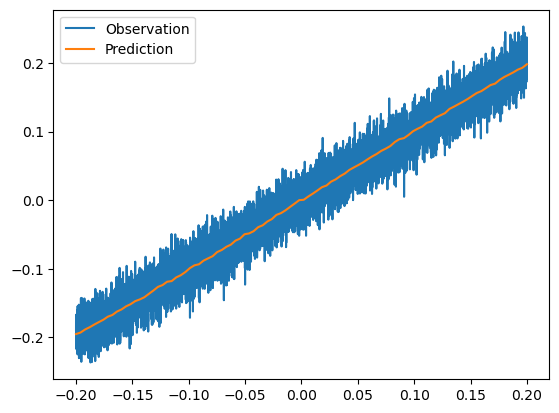

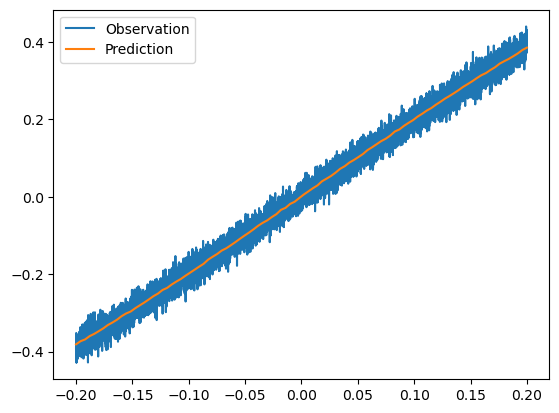

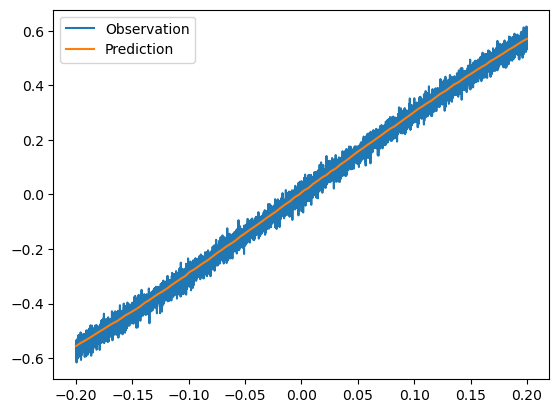

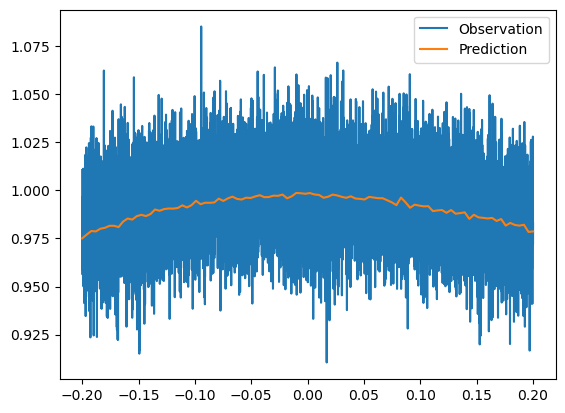

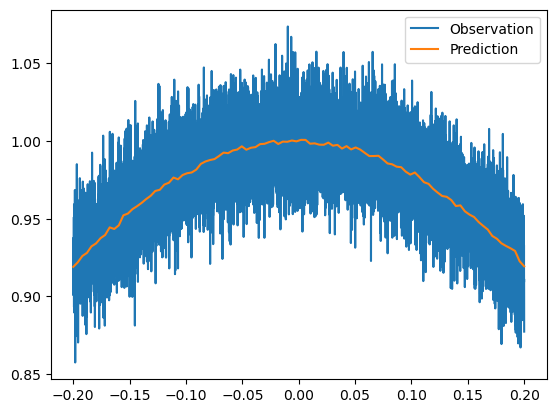

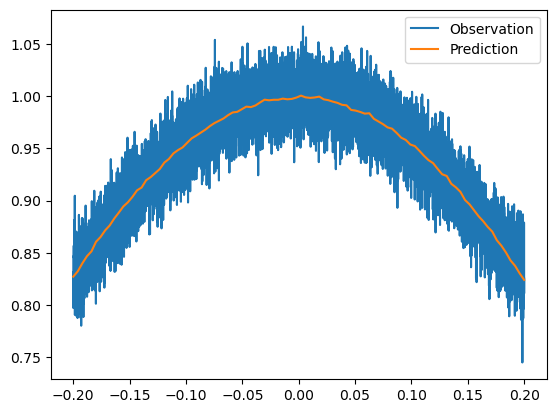

In [9]:
for d in range(6):
    plt.plot(x_obs, y_obs[:,d], label="Observation")
    plt.plot(x_test, y_pred[:,d], label="Prediction")
    plt.legend()
    plt.show()

In [10]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 4.6663e-03, -9.1297e-03,  2.8088e-01, -1.1899e-01, -2.1303e+00,
         4.1598e-03, -2.5908e-03,  1.2736e-02, -8.6649e-03,  9.5921e-03,
         2.9830e+00,  1.5894e-03,  6.0047e-03,  3.3434e+00, -3.7596e+00,
        -7.9966e-03, -2.8357e+00, -5.7798e-03,  1.2099e+00,  7.0927e-03,
        -1.4009e+00, -6.8460e-01, -1.4815e-03, -1.0956e-02,  3.6044e-03,
         4.5994e-03, -4.1382e-04, -2.9936e-03,  1.9805e+00, -8.6608e-03,
        -3.7036e-03, -5.0589e-01, -3.3339e+00, -4.2125e-03,  6.6840e-03,
         2.4139e-03,  3.9317e-03, -5.1689e-03, -4.6358e-03,  1.4537e+00,
         5.6602e-03,  1.6532e-03,  1.2734e-03, -9.3678e-01, -3.1723e-03,
        -7.6529e-04,  2.0137e-03, -5.4939e-03, -2.8948e-03,  4.6596e+00,
        -2.1860e-02, -4.7644e-03,  2.5719e-01, -2.9779e-01,  4.1321e-02,
        -3.4482e-02, -4.8481e-02, -3.2800e-02, -7.7316e-02, -3.8786e-02,
         4.6649e-01,  5.3608e-03,  6.8554e-02,  1.7831e-02,  2.1840e-01,
      